# Multi-agent Collaboration

In [1]:
# Dependency
# !pip install -U langchain langchain_openai langsmith pandas langchain_experimental matplotlib langgraph langchain_core

### Read APIs

In [2]:
import os
openai_api_key = os.getenv('OPENAI_API_KEY')
langchain_api_key = os.getenv('LANGCHAIN_API_KEY')
tavily_api_key = os.getenv('TAVILY_API_KEY')

## Create Tools

In [3]:
from typing import Annotated, List
import fitz  # PyMuPDF
import requests
from io import BytesIO
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from bs4 import BeautifulSoup


tavily_tool = TavilySearchResults(max_results=3)

@tool
def scrape_webpages(urls: List[str]) -> str:
    """
    Use requests and bs4 to scrape the provided web pages for detailed information.
    Args:
        urls (List[str]): A list of URLs to scrape.
    Returns:
        str: A string containing the scraped information
    """
    documents = []
    
    for url in urls:
        try:
            response = requests.get(url)
            response.raise_for_status()  # Check if the request was successful
            soup = BeautifulSoup(response.text, 'html.parser')
            title = soup.title.string if soup.title else 'No Title'
            page_content = soup.get_text()
            documents.append(f'<Document name="{title}">\n{page_content}\n</Document>')
        except requests.exceptions.RequestException as e:
            documents.append(f'<Document name="Error">\nFailed to retrieve {url}: {str(e)}\n</Document>')
    
    return "\n\n".join(documents)

@tool
def extract_pdf_text_from_url(url: str, page_number: int) -> str:
    """
    Extracts text from a specified page number from a PDF file available at a given URL.
    Args:
        url (str): The URL of the PDF file.
        page_number (int): The page number to extract text from (1-based index).
    Returns:
        str: The extracted text from the specified page, limited to 300 words..
    Raises:
        ValueError: If the URL is invalid or the page number exceeds the total pages in the PDF.
    """
    # Download the PDF file
    response = requests.get(url)
    pdf_data = BytesIO(response.content)

    # Open the PDF file
    document = fitz.open(stream=pdf_data, filetype="pdf")

    # Validate the page number
    if page_number < 1 or page_number > len(document):
        raise ValueError("Page number out of range")

    # Extract text from the specified page (0-based index for PyMuPDF)
    page = document.load_page(page_number - 1)
    page_text = page.get_text()

    # Limit the text to 200 words
    words = page_text.split()
    if len(words) > 200:
        words = words[:200]
    limited_text = ' '.join(words)

    return str(limited_text)

## Helper Utilities

In [4]:
from typing import List, Optional
from langchain_core.tools import tool
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, HumanMessage, ToolMessage
from langgraph.graph import END, StateGraph
from langchain_core.messages import AIMessage

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
    team_members: List[str],
) -> str:
    """
    Create a function-calling agent and add it to the graph.
    """
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members will collaborate with you with their own specialties."
    f" You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools,handle_parsing_errors=True)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [AIMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options)) #delete: [, team_members=", ".join(members)]
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )


## Define Agent Teams

In [5]:
import functools
import operator
from typing import Annotated, Sequence, TypedDict
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    #messages: Annotated[Sequence[BaseMessage], operator.add]
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

team_members = ["Search", "WebScraper", "PDFScraper"]

search_agent = create_agent(
    llm,
    [tavily_tool],
    "Search for up-to-date info using the tavily search engine.",
    team_members,
)
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

url_research_agent = create_agent(
    llm,
    [scrape_webpages],
    "Scrape specified urls for more detailed information using the scrape_webpages function."
    "MUST not pass the url for pdf file, only for web pages.",
    team_members,
)
research_node = functools.partial(agent_node, agent=url_research_agent, name="WebScraper")

# pdf_agent
pdf_research_agent = create_agent(
    llm,
    [extract_pdf_text_from_url],
    "Extracts text from a specified page number from a PDF file available at a given URL."
    "clearly predict the page number of the potential information"
    "MUST pass the url for pdf file.",
    team_members
)
pdf_node = functools.partial(agent_node, agent=pdf_research_agent, name="PDFScraper")



supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers:  {team_members}. Given the following user request,respond with the worker to act next."
    "Only pass tavily_search_results_json in format of JSON"
    " Each worker will perform a task and respond with their results and status."
    " When finished, respond with FINISH."
    ,
    team_members,
)

# Define Graph

In [6]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("PDFScraper", pdf_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_edge("PDFScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper","PDFScraper": "PDFScraper", "FINISH": END},
)


research_graph.set_entry_point("supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
# def enter_chain(message: str):
#     results = {
#         "messages": [HumanMessage(content=message)],
#     }
#     return results


# research_chain = enter_chain | chain#(stream_mode="values")

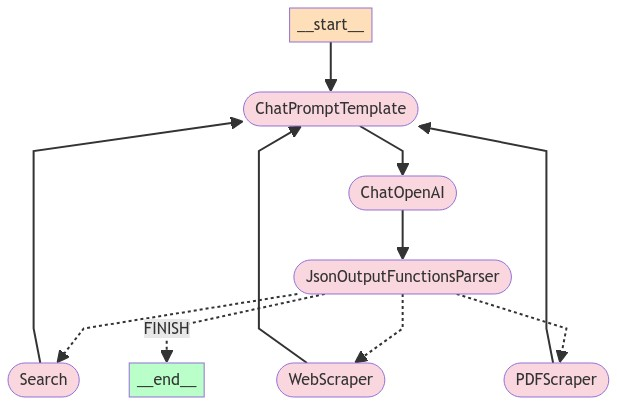

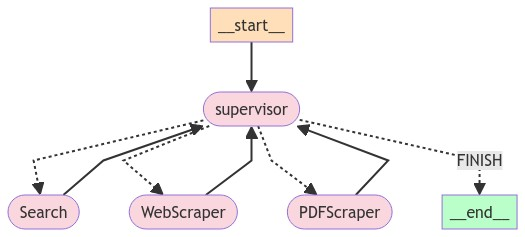

In [7]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))
display(Image(chain.get_graph().draw_mermaid_png()))

In [8]:
# for s in research_chain.stream(
#     "when is Taylor Swift's next tour?", {"recursion_limit": 100}
# ):
#     if "__end__" not in s:
#         print(s)
#         print("---")

In [10]:
url ="https://www.businesswire.com/news/home/20240624893668/en/Seadrill-Initiates-Extension-of-Share-Repurchase-Program"
config = {"configurable": {"thread_id": "1"}}
events = chain.stream(
    {
        "messages": [
            HumanMessage(
                content=
                f"learn from ({url}) "
                " Summary and Fomrat the information in a way that is easy to understand."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    config={"recursion_limit": 50},
    stream_mode="values"
)
for event in events:
    #print(event)
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

learn from (https://www.businesswire.com/news/home/20240624893668/en/Seadrill-Initiates-Extension-of-Share-Repurchase-Program)  Summary and Fomrat the information in a way that is easy to understand.
================================ Human Message =================================

learn from (https://www.businesswire.com/news/home/20240624893668/en/Seadrill-Initiates-Extension-of-Share-Repurchase-Program)  Summary and Fomrat the information in a way that is easy to understand.
================================== Ai Message ==================================
Name: WebScraper

### Summary of Seadrill’s Share Repurchase Program Extension

**Date of Announcement:** June 25, 2024

**Company:** Seadrill Limited (NYSE & OSE: SDRL)

**Location:** Hamilton, Bermuda

#### Key Points:

1. **Completion of Initial Program:**
   - Seadrill completed a $250 million share repurchase program initiated in December 2023.
   

In [11]:
url  = "http://disc.static.szse.cn/download/disc/disk01/finalpage/2013-03-18/21b17fc8-cfa8-42cf-91ed-39a737618de7.PDF"

config = {"configurable": {"thread_id": "1"}}
events = chain.stream(
    {
        "messages": [
            HumanMessage(
                content=
                f"The pdf ({url}) is an ESG report from a company."
                " MUST RETURN (in PDF's language):"
                " 1. The exchange market the company is listed on."
                " 2. The report name."
                " 3. The reporting period."
                " 4. The report release date."
                " 5. The company listed stock name."
                " 6. The company listed stock code."
                " 7. The company full name."
                " 8. The Industry classification of the company's main business operations."
                " Hint: Primary use the PDFScraper, and then confirm with the WebScraper and Search."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    config={"recursion_limit": 50},
    stream_mode="values"
)
for event in events:
    #print(event)
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

The pdf (http://disc.static.szse.cn/download/disc/disk01/finalpage/2013-03-18/21b17fc8-cfa8-42cf-91ed-39a737618de7.PDF) is an ESG report from a company. MUST RETURN (in PDF's language): 1. The exchange market the company is listed on. 2. The report name. 3. The reporting period. 4. The report release date. 5. The company listed stock name. 6. The company listed stock code. 7. The company full name. 8. The Industry classification of the company's main business operations. Hint: Primary use the PDFScraper, and then confirm with the WebScraper and Search.
================================ Human Message =================================

The pdf (http://disc.static.szse.cn/download/disc/disk01/finalpage/2013-03-18/21b17fc8-cfa8-42cf-91ed-39a737618de7.PDF) is an ESG report from a company. MUST RETURN (in PDF's language): 1. The exchange market the company is listed on. 2. The report name. 3. The reporting perio